## Step One, Obtain Data and Visualization 

### 1. Fetch Data from Yahoo Finance API 

In [4]:
import yfinance as yf

tickers = {
    "S&P 500": "^GSPC",
    "VIX": "^VIX",
    "10Y Treasury Yield": "^TNX",
    "13W Treasury Yield": "^IRX",
    "Gold": "GC=F",
    "Nikkei 225": "^N225",
    "BOTZ": "BOTZ",
    "Copper": "HG=F"
}

start_date = "2022-05-30"
end_date = "2024-05-30"


data = {}
for name, ticker in tickers.items():
    data[name] = yf.download(ticker, start_date, end_date)

for name, df in data.items():
    df.to_csv(f"data/{name}_historical_data.csv")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### 2. Visualize Data to Analyse

Visualization of <----S&P 500---->


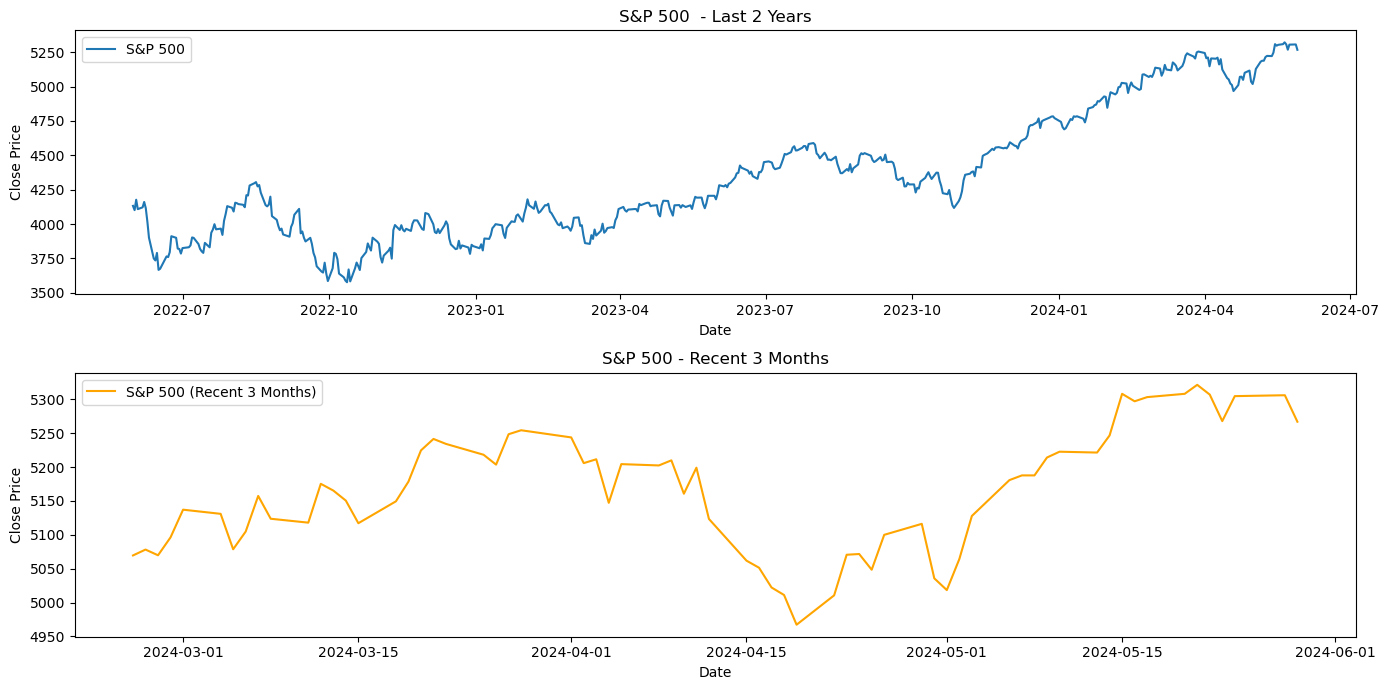

Visualization of <----VIX---->


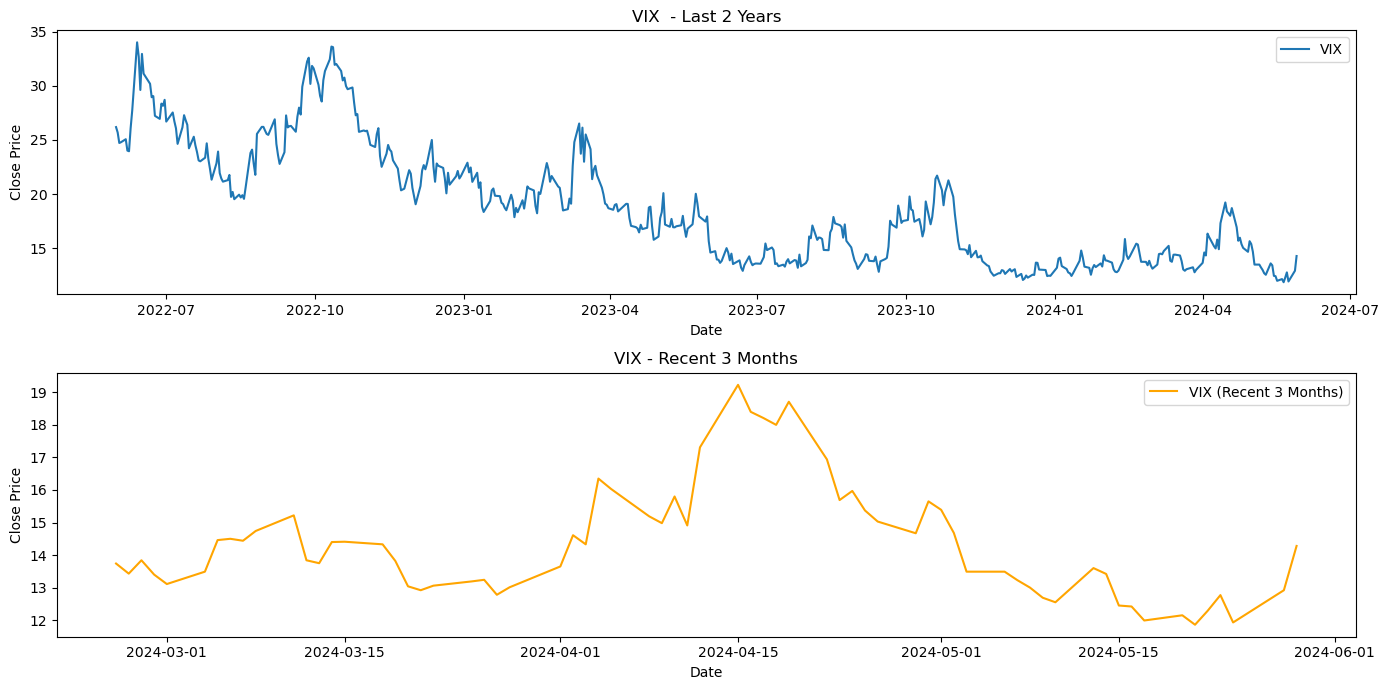

Visualization of <----10Y Treasury Yield---->


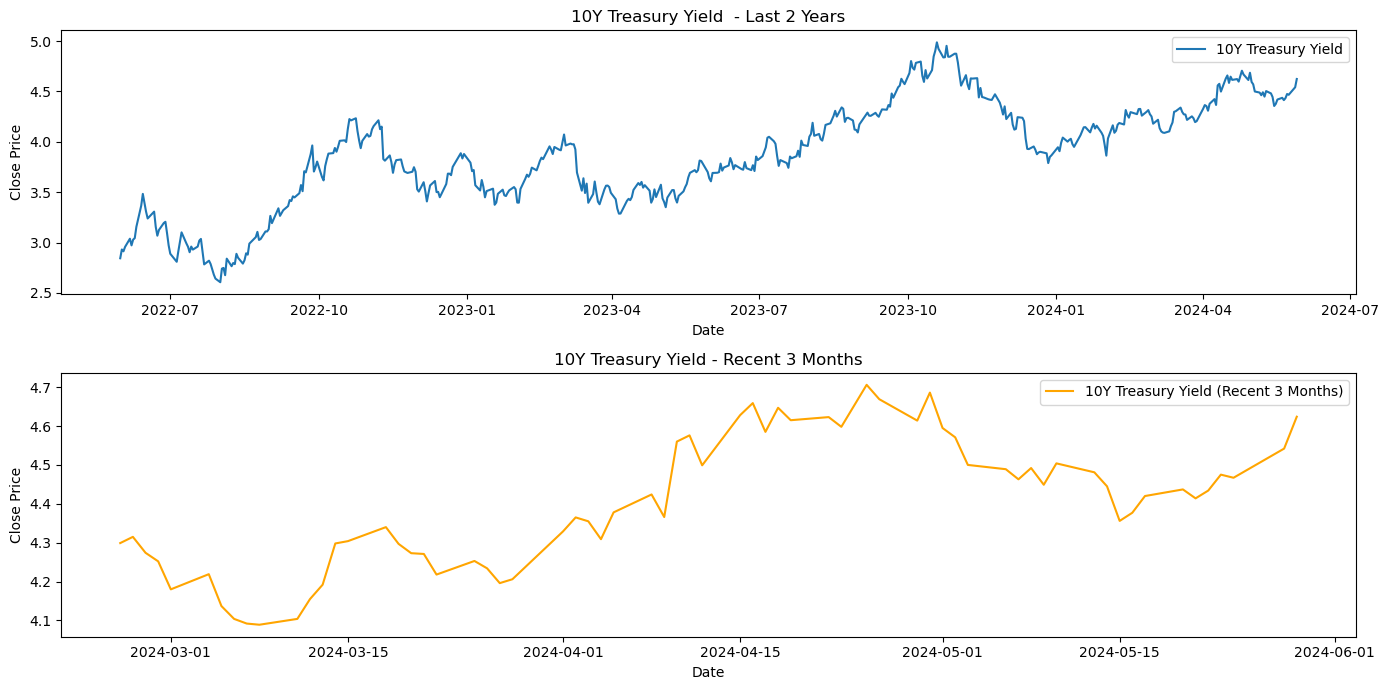

Visualization of <----13W Treasury Yield---->


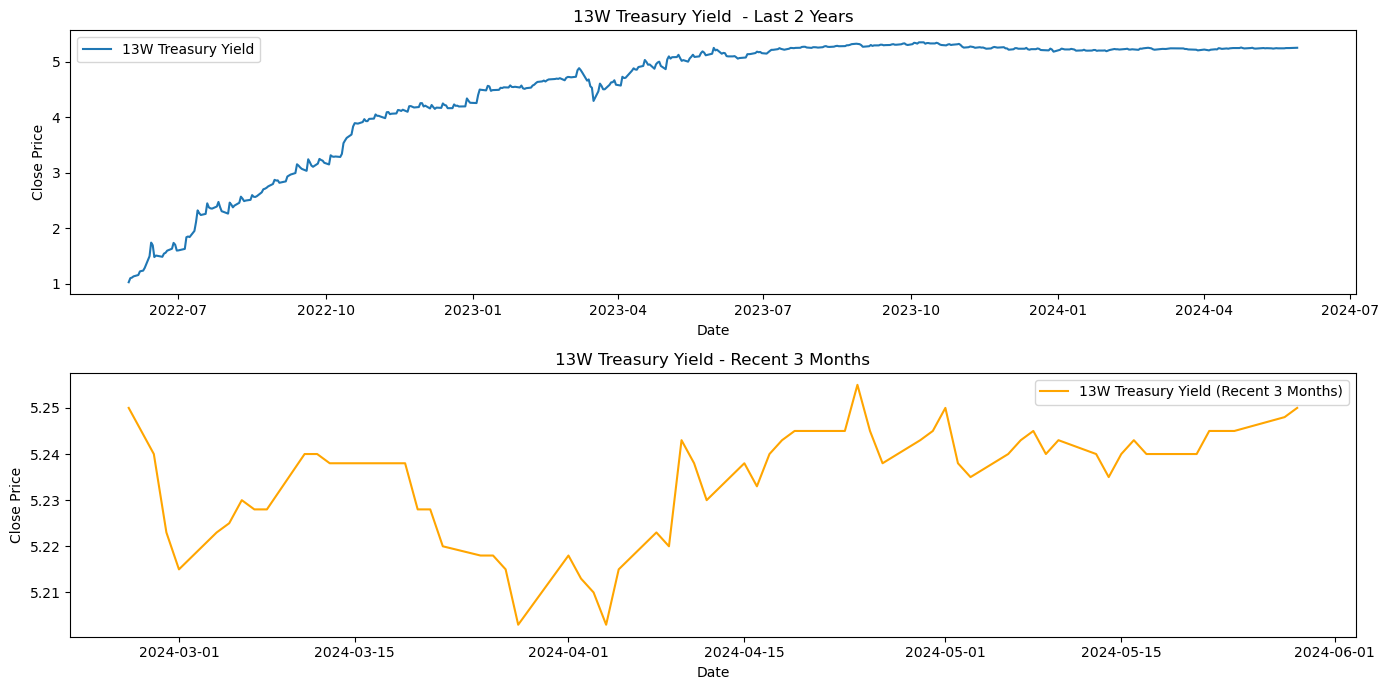

Visualization of <----Gold---->


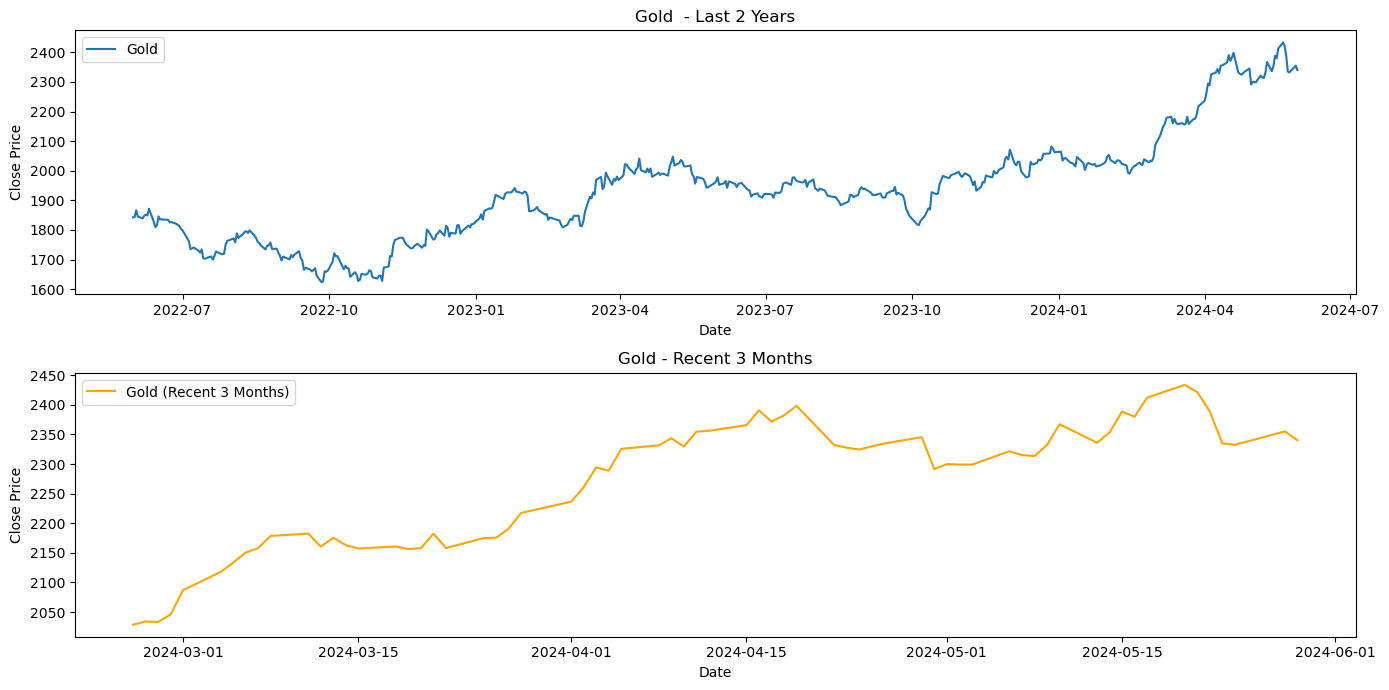

Visualization of <----Nikkei 225---->


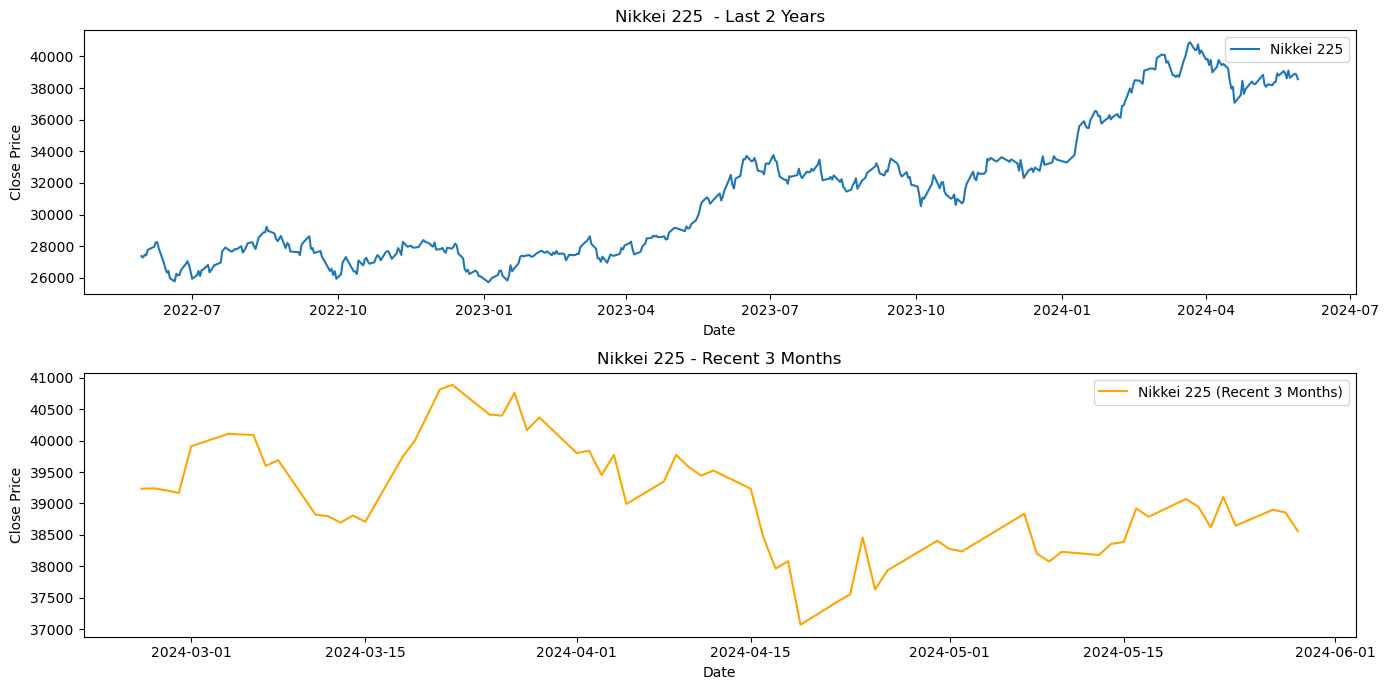

Visualization of <----BOTZ---->


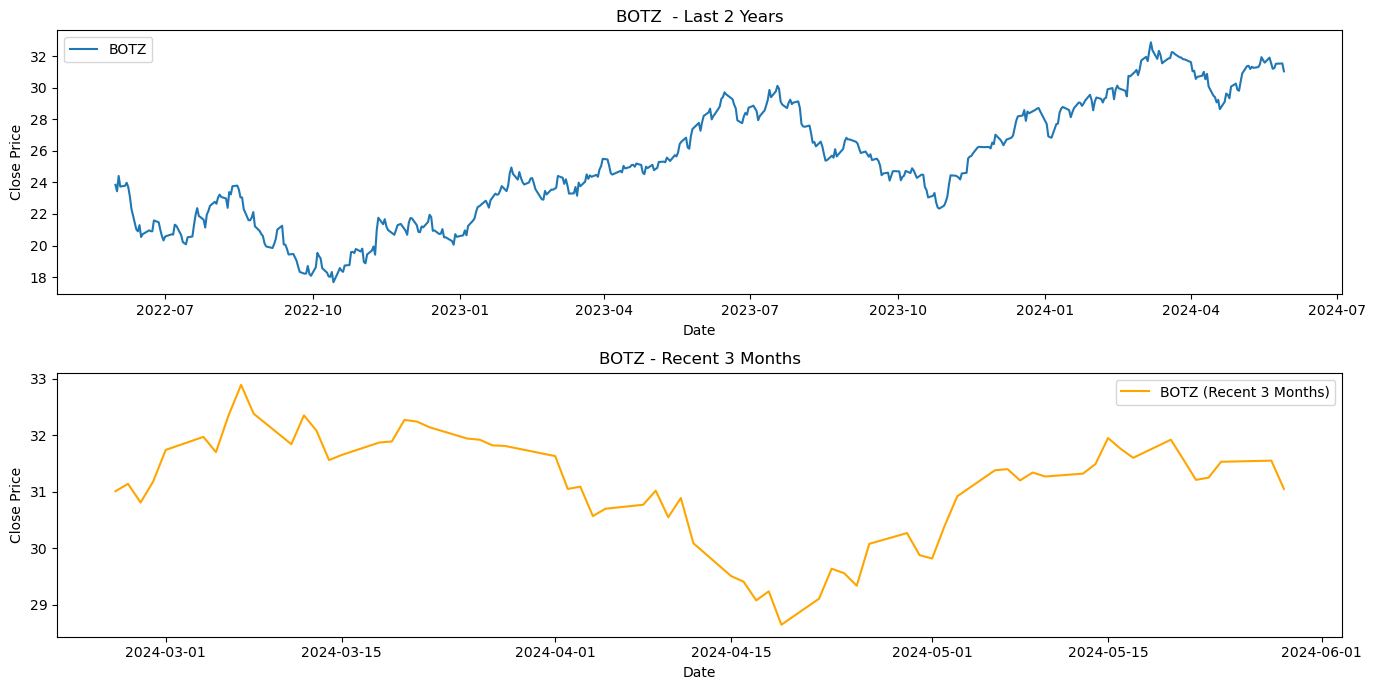

Visualization of <----Copper---->


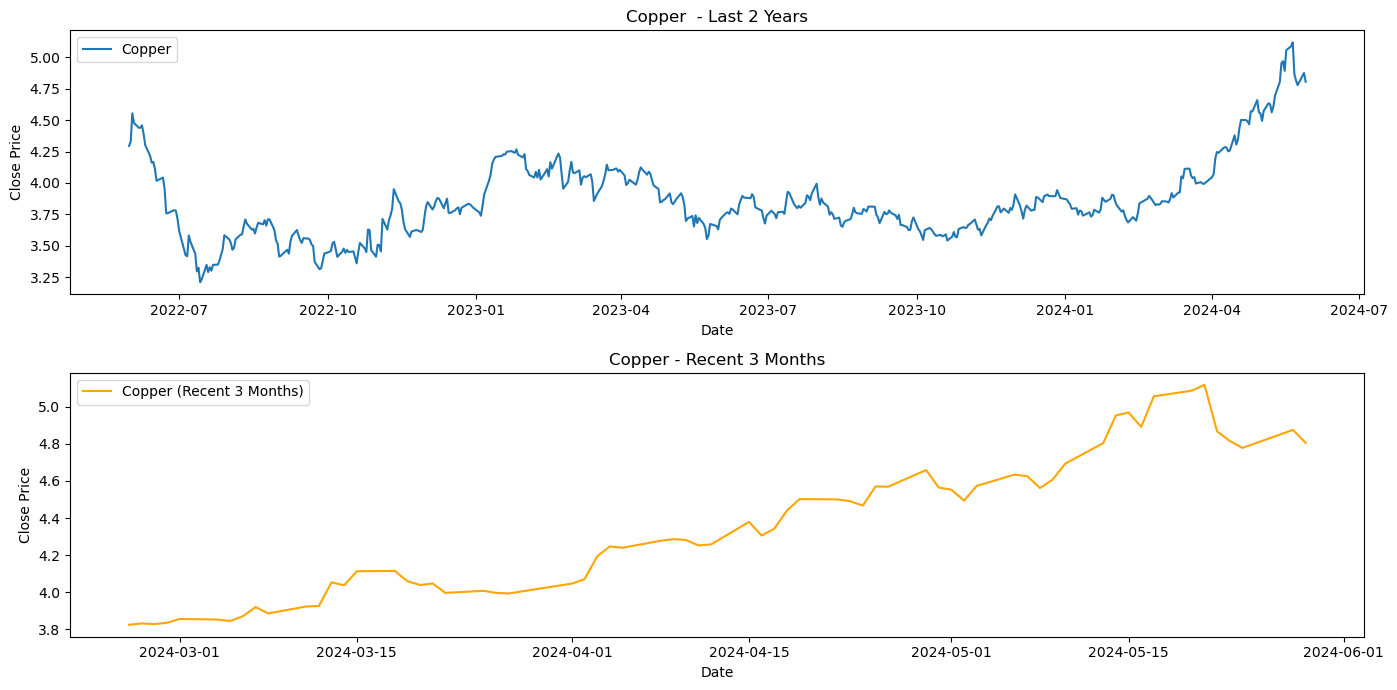

In [5]:
import pandas as pd
import matplotlib.pyplot as plt


for name, df in data.items():
    plt.figure(figsize=(14, 7))

    data_to_visualize = data[name]
    print(f"Visualization of <----{name}---->")

    plt.subplot(2, 1, 1)
    plt.plot(data_to_visualize.index, data_to_visualize ['Close'], label=f'{name}')
    plt.title(f'{name}  - Last 2 Years')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()

    date_3m = "2024-02-26"

    recent_data = data_to_visualize[date_3m:]
    plt.subplot(2, 1, 2)
    plt.plot(recent_data.index, recent_data['Close'], label=f'{name} (Recent 3 Months)', color='orange')
    plt.title(f'{name} - Recent 3 Months')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Step2, Customize Product for Client A

### 1. Define Risk Free Rate

By feature analysis, we consider a snowball like (by setting knock-in and knock-out lines) can bring client A with high return and low risk. In order to price the snowball like product, we will divide the 2 year periond into 8 quarters, and each month is a observation periond. After simulation, we will use the rates in the oberservation period for data modeling if knock-in or knock-out takes place in any day in the month.

According to the historical data of US 13-week and 5-year treasury yield, we anticipate the risk-free rate won't change a lot in the coming year. So for the first 4 quarters we assume the invester can buy 13-week treasury bond 4 times all at the yield of 5.2%. While considering the market anticipation of lowering the US interest rate by the federal reserve since the lowering unemployment rate, we downturn the risk free rate to be 4.7% which is above the yield of 5-year bond yield.

In [156]:
rf_first = 0.052
rf_second = 0.047

### 2.Find the Optimal Portfolio According to Efficient Frontier

In [9]:
# Client A's Target Asset: Nikkei 225, BOTZ (Global X Robotics & Artificial Intelligence ETF), Gold and Copper Futures
import numpy as np
from scipy.optimize import minimize

ta_list = ["Nikkei 225", "BOTZ", "Gold", "Copper"]

ta_past_returns = {}
for ticker in ta_list:
    ta_past_returns[ticker] = data[ticker]['Close'].pct_change().dropna()

returns_df = pd.DataFrame(ta_past_returns).dropna()
corr_matrix = returns_df.corr()
mean_returns = returns_df.mean()
cov_matrix = returns_df.cov()
std_dev = returns_df.std()

annual_mean_returns = mean_returns * 252
annual_std_dev = std_dev * np.sqrt(252)
annual_sharp = (annual_mean_returns - rf_first)/annual_std_dev
performance = pd.concat([annual_mean_returns, annual_std_dev, annual_sharp], axis=1)
performance.columns = ['Annual Returns', 'Annual Std', 'Annual Sharpe']


In [10]:
print(len(returns_df))
print("<-----> Correlation Matrix <----->")
print(corr_matrix)
print("\n<-----> Average Return (Daily) <----->")
print(mean_returns)
print("\n<-----> Covarance Matrix <----->")
print(cov_matrix)
print("\n<-----> Individual Performance <----->")
print(performance)



473
<-----> Correlation Matrix <----->
            Nikkei 225      BOTZ      Gold    Copper
Nikkei 225    1.000000  0.196691 -0.029955  0.075359
BOTZ          0.196691  1.000000  0.258435  0.305116
Gold         -0.029955  0.258435  1.000000  0.415217
Copper        0.075359  0.305116  0.415217  1.000000

<-----> Average Return (Daily) <----->
Nikkei 225    0.000734
BOTZ          0.000457
Gold          0.000636
Copper        0.000284
dtype: float64

<-----> Covarance Matrix <----->
            Nikkei 225      BOTZ      Gold    Copper
Nikkei 225    0.000118  0.000035 -0.000003  0.000012
BOTZ          0.000035  0.000266  0.000037  0.000074
Gold         -0.000003  0.000037  0.000076  0.000054
Copper        0.000012  0.000074  0.000054  0.000220

<-----> Individual Performance <----->
            Annual Returns  Annual Std  Annual Sharpe
Nikkei 225        0.184962    0.172402       0.771235
BOTZ              0.115059    0.259012       0.243461
Gold              0.160236    0.138136       0.7

0.10673563899222163 0.17114604360632804
[4.41243977e-01 1.35572377e-16 5.58756023e-01 0.00000000e+00]
0.10559382960546589 0.1651804542253982
[0.37601659 0.03053755 0.55994895 0.03349692]


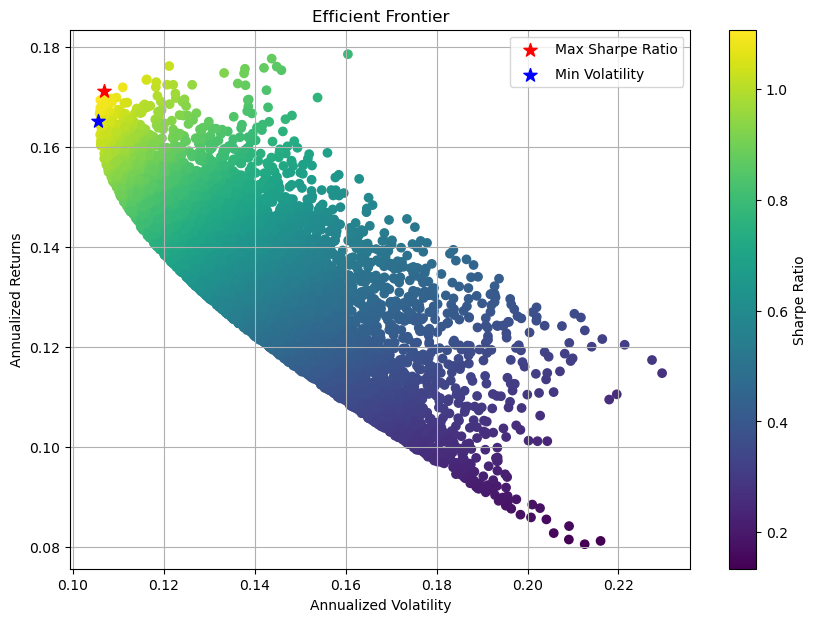

In [11]:
def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def maximize_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = minimize(negative_sharpe_ratio, num_assets * [1. / num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualized_performance(weights, mean_returns, cov_matrix)[0]

def minimize_volatility(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = minimize(portfolio_volatility, num_assets * [1. / num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

risk_free_rate = rf_first # use the current risk free rate as past two years'

# Find the max sharp ratio
max_sharpe = maximize_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
max_sharpe_allocation = max_sharpe['x']
max_sharpe_perf = portfolio_annualized_performance(max_sharpe_allocation, mean_returns, cov_matrix)
print(max_sharpe_perf[0],max_sharpe_perf[1])
print(max_sharpe_allocation)

# Find the min voltility
min_vol = minimize_volatility(mean_returns, cov_matrix)
min_vol_allocation = min_vol['x']
min_vol_perf = portfolio_annualized_performance(min_vol_allocation, mean_returns, cov_matrix)
print(min_vol_perf[0], min_vol_perf[1])
print(min_vol_allocation)

# Efficient frontier
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3, 10000))
    for i in range(10000):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev

    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:], results[1,:], c=results[2,:], marker='o')
    plt.grid(True)
    plt.xlabel('Annualized Volatility')
    plt.ylabel('Annualized Returns')
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(max_sharpe_perf[0], max_sharpe_perf[1], marker='*', color='red', s=100, label='Max Sharpe Ratio')
    plt.scatter(min_vol_perf[0], min_vol_perf[1], marker='*', color='blue', s=100, label='Min Volatility')
    plt.title('Efficient Frontier')
    plt.legend(labelspacing=0.8)
    plt.show()

display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)


### 3. Adjust Weight According to Projection
Nikki 225: 35%
BOTZ: 5%
Gold: 55%
Copper: 5%

In [38]:
weight = np.array([0.35, 0.05, 0.55, 0.05])
std, annual_return  = portfolio_annualized_performance(weight, mean_returns, cov_matrix)
sharp = (annual_return-rf_first)/std
print(f" Portflio Risk: {std}\n Portfolio Return: {annual_return}\n Portfolio Sharp: {sharp}")

 Portflio Risk: 0.10585308980344751
 Portfolio Return: 0.1621931079978239
 Portfolio Sharp: 1.0410003921702724


Snowball Price (NPV): 113.86574021733159
Expect Return (End of Term): 0.11989613968411628
Stistical Volatility: 0.0763901366538402
Knock-out Percentage: 0.7312
Knock-out Over 1 Year Percentage 0.6900984682713348


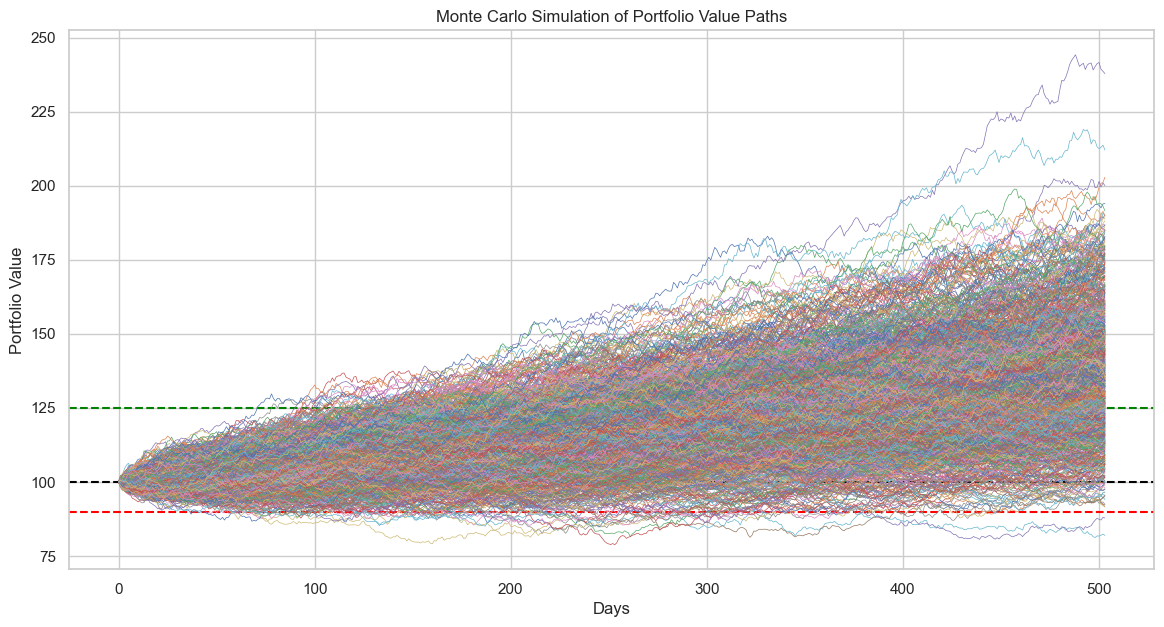

In [182]:
# This is the first version not encapsluted in functions
import numpy as np
import matplotlib.pyplot as plt

initial_value = 100
num_simulations = 10000
years = 2
time_horizon = 252 * years
expected_return = annual_return
volatility = std
monthly_steps = 21  # Examine Every Month
knock_out_level = 1.25
knock_in_level = 0.9
annual_coupon = 0.08
bonus_year1 = 0.17
bonus_year2 = 0.12

daily_return = (1 + expected_return) ** (1 / 252) - 1
daily_volatility = volatility / np.sqrt(252)

simulated_paths = np.zeros((time_horizon, num_simulations))
simulated_paths[0] = initial_value

for t in range(1, time_horizon):
    random_shocks = np.random.normal(daily_return, daily_volatility, num_simulations)
    simulated_paths[t] = simulated_paths[t - 1] * np.exp(random_shocks)

final_payoffs = np.zeros(num_simulations)
knock_out_count = knock_out_over_1y = 0


final_payoffs = np.zeros(num_simulations)
knock_out_count = 0
knock_out_over_1y = 0

for i in range(num_simulations):
    path = simulated_paths[:, i]
    knock_out = False
    for j in range(1, time_horizon, monthly_steps):
        if path[j] >= knock_out_level * initial_value:
            knock_out = True
            knock_out_count += 1
            if j <= 252:
                discount_factor = np.exp(-rf_first * j / 252)
                final_payoffs[i] = initial_value * (1 + (annual_coupon + bonus_year1) * (j / 252)) * discount_factor
            else:
                discount_factor1 = np.exp(-rf_first * 252 / 252)
                discount_factor2 = np.exp(-rf_second * (j - 252) / 252)
                final_payoffs[i] = initial_value * (1 + (annual_coupon + bonus_year2) * (j / 252)) * discount_factor1 * discount_factor2
                knock_out_over_1y += 1
            break
    if not knock_out:
        discount_factor1 = np.exp(-rf_first * 252 / 252)
        discount_factor2 = np.exp(-rf_second * (time_horizon - 252) / 252)
        discount_factor = discount_factor1 * discount_factor2
        if np.any(path <= knock_in_level * initial_value):
            final_payoffs[i] = path[-1] * discount_factor 
        else:
            final_payoffs[i] = initial_value * (1 + annual_coupon * 2) * discount_factor

product_price = np.mean(final_payoffs)
print("Snowball Price (NPV):", product_price)

expected_return = (np.mean(final_payoffs) / initial_value*(1+rf_first)*(1+rf_second))**(1/2)-1
volatility = np.std(final_payoffs / initial_value)

print("Expect Return (End of Term):", expected_return)
print("Stistical Volatility:", volatility)
knock_out_ratio = knock_out_count / num_simulations
print("Knock-out Percentage:", knock_out_ratio)
knock_out_ratio_over_1y = knock_out_over_1y/knock_out_count 
print("Knock-out Over 1 Year Percentage", knock_out_ratio_over_1y)

plt.figure(figsize=(14, 7))
plt.axhline(initial_value, color='black', linestyle='--', label='Initial Value')
plt.axhline(knock_out_level * initial_value, color='green', linestyle='--', label='Knock Out Level')
plt.axhline(knock_in_level * initial_value, color='red', linestyle='--', label='Knock In Level')
for i in range(1000):  
    plt.plot(simulated_paths[:, i], lw=0.5)
plt.title('Monte Carlo Simulation of Portfolio Value Paths')
plt.xlabel('Days')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()

In [252]:
# Final Version with level simulations

def simulate_snowball(initial_value, num_simulations, years, expected_return, volatility, knock_in_level, knock_out_level, annual_coupon, rf_first, rf_second, bonus_year1, bonus_year2):
    time_horizon = 252 * years
    monthly_steps = 21  # Examine Every Month
    
    daily_return = (1 + expected_return) ** (1 / 252) - 1
    daily_volatility = volatility / np.sqrt(252)
    
    simulated_paths = np.zeros((time_horizon, num_simulations))
    simulated_paths[0] = initial_value

    for t in range(1, time_horizon):
        random_shocks = np.random.normal(daily_return, daily_volatility, num_simulations)
        simulated_paths[t] = simulated_paths[t - 1] * np.exp(random_shocks)

    final_payoffs = np.zeros(num_simulations)
    knock_out_count = 0
    knock_out_over_1y = 0

    for i in range(num_simulations):
        path = simulated_paths[:, i]
        knock_out = False
        for j in range(1, time_horizon, monthly_steps):
            if path[j] >= knock_out_level * initial_value:
                knock_out = True
                knock_out_count += 1
                if j <= 252:
                    discount_factor = np.exp(-rf_first * j / 252)
                    final_payoffs[i] = initial_value * (1 + (annual_coupon + bonus_year1) * (j / 252)) * discount_factor
                else:
                    discount_factor1 = np.exp(-rf_first * 252 / 252)
                    discount_factor2 = np.exp(-rf_second * (j - 252) / 252)
                    final_payoffs[i] = initial_value * (1 + (annual_coupon + bonus_year2) * (j / 252)) * discount_factor1 * discount_factor2
                    knock_out_over_1y += 1
                break
        if not knock_out:
            discount_factor1 = np.exp(-rf_first * 252 / 252)
            discount_factor2 = np.exp(-rf_second * (time_horizon - 252) / 252)
            discount_factor = discount_factor1 * discount_factor2
            if np.any(path <= knock_in_level * initial_value):
                final_payoffs[i] = path[-1] * discount_factor 
            else:
                final_payoffs[i] = initial_value * (1 + annual_coupon * 2) * discount_factor

    product_price = np.mean(final_payoffs)
    expected_return = np.mean(final_payoffs) / initial_value - 1
    volatility = np.std(final_payoffs / initial_value)
    sharp_ratio = (((1+ expected_return)*(1+rf_first)*(1+rf_second))**(1/2)-1 - 0.0495) / volatility

    results = {
        "knock_in_level": knock_in_level,
        "knock_out_level": knock_out_level,
        "product_price": product_price,
        "expected_return": ((1+ expected_return)*(1+rf_first)*(1+rf_second))**(1/2)-1, #expected_return + 1/2 * (rf_first + rf_second),
        "volatility": volatility,
        "sharp_ratio": sharp_ratio,
        "knock_out_ratio": knock_out_count / num_simulations,
        "knock_out_ratio_over_1y": knock_out_over_1y / knock_out_count if knock_out_count > 0 else 0,
        "paths": simulated_paths
    }
    
    return results

# Simulate Knock-in Level [0.7, 0.9] and Knock-out Level [1.1, 1.5] by interval 0.05
def optimize_snowball(initial_value, num_simulations, years, expected_return, volatility, annual_coupon, rf_first, rf_second, bonus_year1, bonus_year2):
    results_list = []
    for knock_in_level in np.arange(0.7, 0.95, 0.05):
        for knock_out_level in np.arange(1.1, 1.55, 0.05):
            results = simulate_snowball(
                initial_value, num_simulations, years, expected_return, volatility, 
                knock_in_level, knock_out_level, annual_coupon, rf_first, rf_second,
                bonus_year1, bonus_year2
            )
            results_list.append(results)
    
    results_df = pd.DataFrame(results_list)
    best_index = results_df["sharp_ratio"].idxmax()
    best_result = results_df.loc[best_index]
    
    return results_df.drop(columns=["paths"]), best_result.drop(labels=["paths"])

def visualize_snowball_paths(simulated_paths, initial_value, knock_in_level, knock_out_level):
    plt.figure(figsize=(14, 7))
    plt.axhline(initial_value, color='black', linestyle='--', label='Initial Value')
    plt.axhline(knock_out_level * initial_value, color='green', linestyle='--', label='Knock Out Level')
    plt.axhline(knock_in_level * initial_value, color='red', linestyle='--', label='Knock In Level')

    for i in range(100):  # Draw the first 100 paths
        plt.plot(simulated_paths[:, i], lw=0.5)
    plt.title('Monte Carlo Simulation of Portfolio Value Paths')
    plt.xlabel('Days')
    plt.ylabel('Portfolio Value')
    plt.grid(True)
    plt.legend()
    plt.show()


In [253]:
# Initialize Parameters (Can be adjusted)
initial_value = 100
num_simulations = 10000
years = 2
expected_return = annual_return
volatility = std
annual_coupon = 0.09
bonus_year1 = 0.18
bonus_year2 = 0.12

results_df, best_result = optimize_snowball(
    initial_value, num_simulations, years,
    expected_return, volatility,
    annual_coupon, rf_first, rf_second,
    bonus_year1, bonus_year2
)

print("Best Result:")
print(best_result) # Best result will always be the boardest levels

Best Result:
knock_in_level                   0.75
knock_out_level                   1.2
product_price              118.214581
expected_return              0.127956
volatility                   0.062101
sharp_ratio                  1.263357
knock_out_ratio                0.8246
knock_out_ratio_over_1y      0.540868
Name: 11, dtype: object


In [254]:
print("All Results:")
print(results_df)

results_df.to_csv('product_data/product_design.csv')

All Results:
    knock_in_level  knock_out_level  product_price  expected_return  \
0             0.70             1.10     114.133783         0.108316   
1             0.70             1.15     116.832183         0.121341   
2             0.70             1.20     118.253757         0.128143   
3             0.70             1.25     118.469866         0.129173   
4             0.70             1.30     118.193907         0.127857   
5             0.70             1.35     117.088609         0.122571   
6             0.70             1.40     115.992626         0.117305   
7             0.70             1.45     114.730020         0.111207   
8             0.70             1.50     113.569635         0.105574   
9             0.75             1.10     114.009748         0.107714   
10            0.75             1.15     116.866360         0.121505   
11            0.75             1.20     118.214581         0.127956   
12            0.75             1.25     118.369433         0.128

### 4. Find the Most Suitable Parameters for Snowball Product with Data Visualisation
We consider 3 main factors on choosing parameters: 
1. expected return > 0.12 & volatility < 0.1
2. reasonable possibility to knock out between year1 and year2 
3. sharp ratrio within 2 to make it profitable for finance institution. 

P.S. We will set a higher bonus on knock-outs in the first year because the client's expectation is 1-2 years. Once the portfolio index knocks out in the first year accidentally, the client could have more payment for insurance.

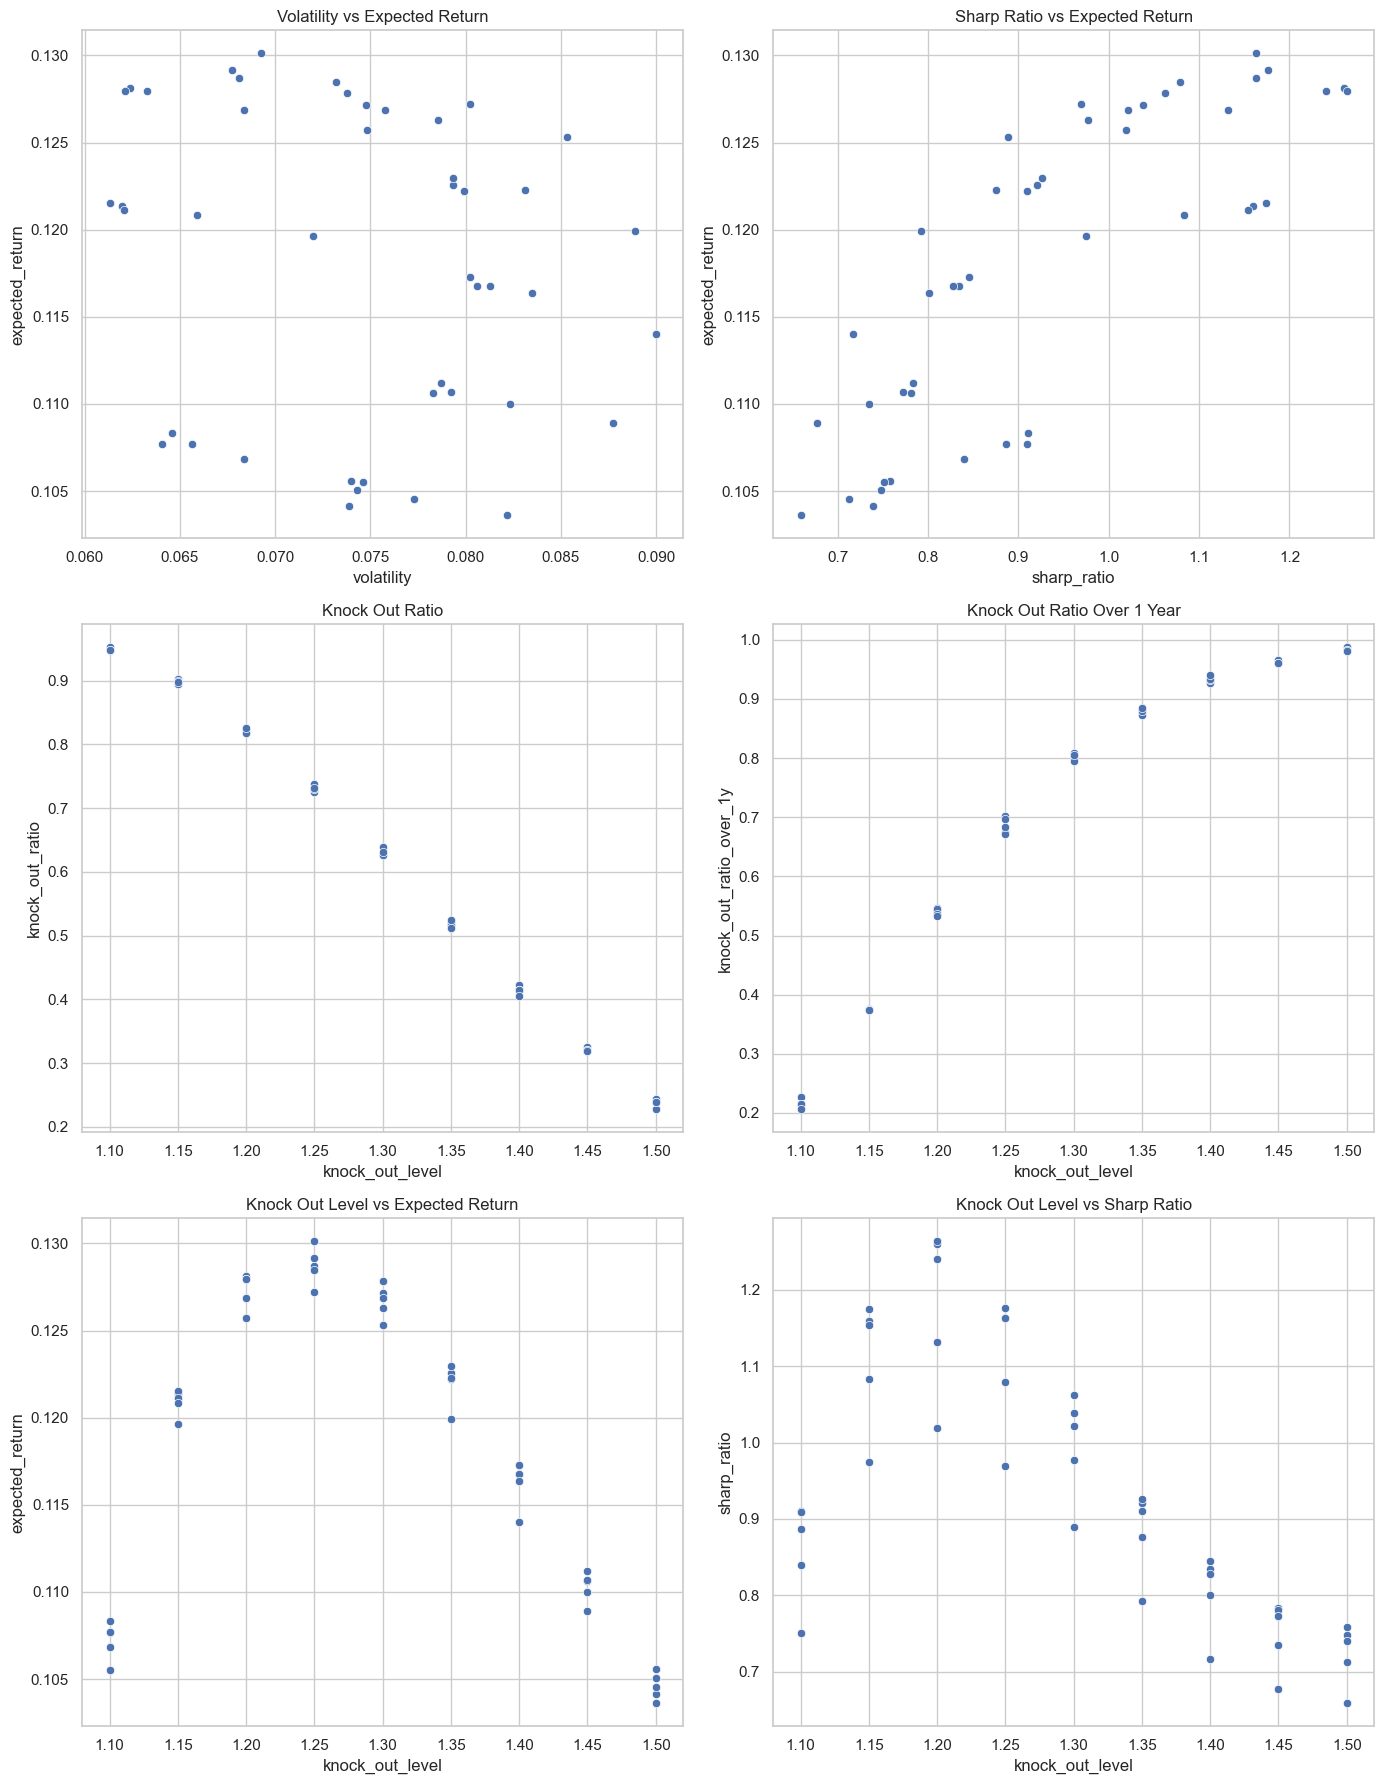

In [255]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 18))

# volatility vs expected return
sns.scatterplot(ax=axes[0, 0], x='volatility', y='expected_return', data = results_df)
axes[0, 0].set_title('Volatility vs Expected Return')

# sharp ratio vs expected return
sns.scatterplot(ax=axes[0, 1], x='sharp_ratio', y='expected_return', data = results_df)
axes[0, 1].set_title('Sharp Ratio vs Expected Return')

# knock out level vs knock out ratio
sns.scatterplot(ax=axes[1, 0], x='knock_out_level', y='knock_out_ratio', data = results_df)
axes[1, 0].set_title('Knock Out Ratio')

# knock out level vs knock out after the first year/total knock out 
sns.scatterplot(ax=axes[1, 1], x='knock_out_level', y='knock_out_ratio_over_1y', data = results_df)
axes[1, 1].set_title('Knock Out Ratio Over 1 Year')

# knock out level vs expected return
sns.scatterplot(ax=axes[2, 0], x='knock_out_level', y='expected_return', data = results_df)
axes[2, 0].set_title('Knock Out Level vs Expected Return')

# knock out level vs sharp ratio
sns.scatterplot(ax=axes[2, 1], x='knock_out_level', y='sharp_ratio', data = results_df)
axes[2, 1].set_title('Knock Out Level vs Sharp Ratio')


plt.tight_layout()
plt.show()


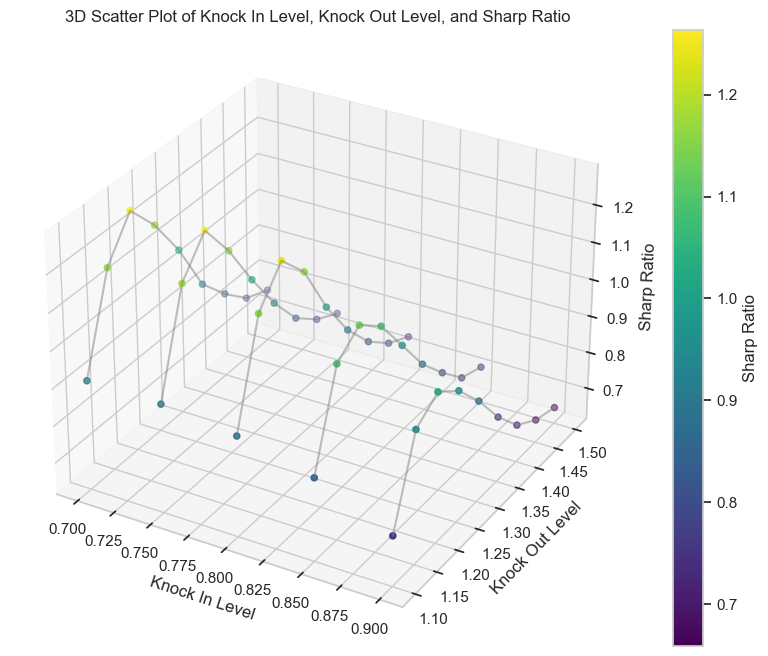

In [256]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3D Scatter Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(results_df['knock_in_level'], results_df['knock_out_level'], results_df['sharp_ratio'],
                     c=results_df['sharp_ratio'], cmap='viridis', marker='o')

knock_in_levels = results_df['knock_in_level'].unique()
for knock_in_level in knock_in_levels:
    subset = results_df[results_df['knock_in_level'] == knock_in_level]
    ax.plot(subset['knock_in_level'], subset['knock_out_level'], subset['sharp_ratio'], color='gray', alpha=0.5)

ax.set_xlabel('Knock In Level')
ax.set_ylabel('Knock Out Level')
ax.set_zlabel('Sharp Ratio')
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Sharp Ratio')
ax.set_title('3D Scatter Plot of Knock In Level, Knock Out Level, and Sharp Ratio')

plt.show()


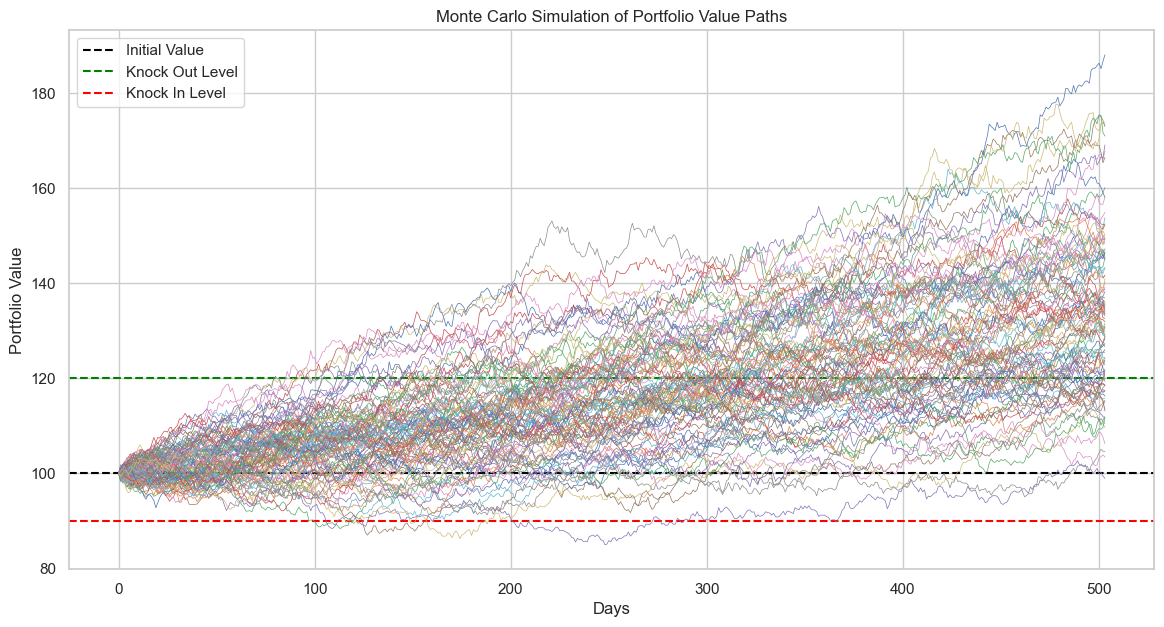

                                  0
knock_in_level             0.900000
knock_out_level            1.200000
product_price            117.767005
expected_return            0.125819
volatility                 0.074683
sharp_ratio                1.021897
knock_out_ratio            0.823800
knock_out_ratio_over_1y    0.540301


In [257]:
# Visualization any of the choice above
knock_in_level = 0.9
knock_out_level = 1.2

results = simulate_snowball(
    initial_value, num_simulations, years,
    expected_return, volatility,
    knock_in_level, knock_out_level,
    annual_coupon, rf_first, rf_second,
    bonus_year1, bonus_year2
)
visualize_snowball_paths(results["paths"], initial_value, knock_in_level, knock_out_level)
del results['paths']
print(pd.DataFrame(results,index=[0]).T)


### 5. BackTest On Last 2 Years Data

BackTest Results:
End of Term Value: 124.87223272963206
Annual Return: 0.13251168388725748


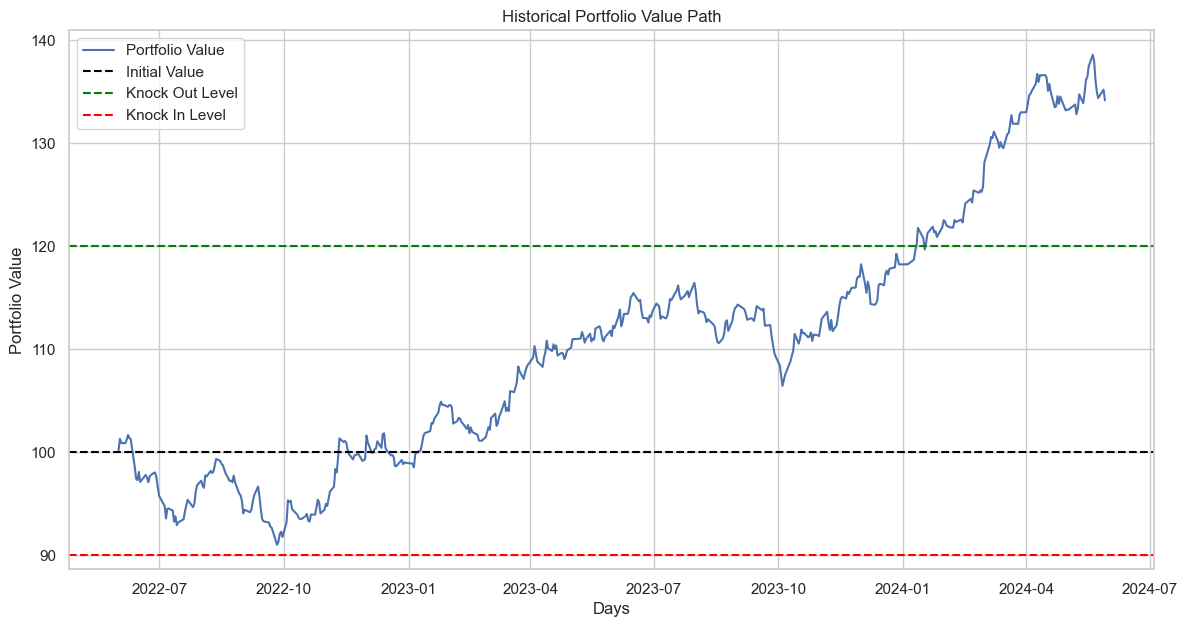

In [258]:

portfolio_returns = returns_df.dot(weight)

initial_value = 100
portfolio_values = initial_value * (1 + portfolio_returns).cumprod()

knock_in_level = 0.9 * initial_value
knock_out_level = 1.2 * initial_value
annual_coupon = 0.052
bonus_year1 = 0.1
bonus_year2 = 0.09
rf_first = 0.025
rf_second = 0.05
# BackTest
def backtest_snowball(portfolio_values, knock_in_level, knock_out_level, annual_coupon, rf_first, rf_second, bonus_year1, bonus_year2):
    time_horizon = len(portfolio_values)
    monthly_steps = 21 
    final_payoff = 0
    knock_out = False

    for j in range(0, time_horizon, monthly_steps):
        if portfolio_values.iloc[j] >= knock_out_level:
            knock_out = True
            if j < 252:
                discount_factor = np.exp(-rf_first * j / 252)
                final_payoff = initial_value * (1 + (annual_coupon + bonus_year1) * (j / 252)) * discount_factor
            else:
                discount_factor1 = np.exp(-rf_first * 252 / 252)
                discount_factor2 = np.exp(-rf_second * (j - 252) / 252)
                final_payoff = initial_value * (1 + (annual_coupon + bonus_year2) * (j / 252)) * discount_factor1 * discount_factor2
            break

    if not knock_out:
        discount_factor1 = np.exp(-rf_first * 252 / 252)
        discount_factor2 = np.exp(-rf_second * (time_horizon - 252) / 252)
        discount_factor = discount_factor1 * discount_factor2
        if np.any(portfolio_values <= knock_in_level):
            final_payoff = portfolio_values.iloc[-1] * discount_factor
        else:
            final_payoff = initial_value * (1 + annual_coupon * 2) * discount_factor
    annual_return = (final_payoff * (1+rf_first) * (1+rf_second)/ initial_value - 1) ** 1/(time_horizon / 252)

    results = {
        "final_payoff": final_payoff * (1+rf_first) * (1+rf_second),
        "annual_return": annual_return,
    }
    
    return results

results = backtest_snowball(portfolio_values, knock_in_level, knock_out_level, annual_coupon, rf_first, rf_second, bonus_year1, bonus_year2)

print("BackTest Results:")
print("End of Term Value:", results["final_payoff"])
print("Annual Return:", results["annual_return"])


plt.figure(figsize=(14, 7))
plt.plot(portfolio_values, label='Portfolio Value')
plt.axhline(initial_value, color='black', linestyle='--', label='Initial Value')
plt.axhline(knock_out_level, color='green', linestyle='--', label='Knock Out Level')
plt.axhline(knock_in_level, color='red', linestyle='--', label='Knock In Level')
plt.title('Historical Portfolio Value Path')
plt.xlabel('Days')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()


Point: Knock in level control more on risks while knock out level control more on returns in this case. We encourage knock out for higher return since the portfolio index is expected to grow in the coming two years. Thus, a bigger difference between annual coupon and bonus can lead to higher volatility.

## Step3, Customize Product for Client C

In [225]:
SOFR_Data = pd.read_csv("data/DGS10.csv")
SOFR_Data.head()


,DATE,DGS10
0,1962-01-02,4.06
1,1962-01-03,4.03
2,1962-01-04,3.99
3,1962-01-05,4.02
4,1962-01-08,4.03


In [260]:

SOFR_Data['DATE'] = pd.to_datetime(SOFR_Data['DATE'])

start_date = SOFR_Data['DATE'].max() - pd.DateOffset(years=20)
recent_data = SOFR_Data[SOFR_Data['DATE'] >= start_date]


cleaned_data = recent_data.dropna()
non_numeric_values = cleaned_data[~cleaned_data['DGS10'].apply(lambda x: x.replace('.', '', 1).isdigit())]
cleaned_data = cleaned_data[cleaned_data['DGS10'].apply(lambda x: x.replace('.', '', 1).isdigit())]
cleaned_data['DGS10'] = pd.to_numeric(cleaned_data['DGS10'])

# Calculate the historical range of the 10-year SOFR in the past 10 years
min_yield = cleaned_data['DGS10'].min()
max_yield = cleaned_data['DGS10'].max()

lower_bound = np.percentile(cleaned_data['DGS10'], 20) 
upper_bound = np.percentile(cleaned_data['DGS10'], 80)  

(lower_bound, upper_bound, min_yield, max_yield)

# Calculate the proportion of days the 10-year SOFR stayed within the range
in_range_days = cleaned_data[(cleaned_data['DGS10'] >= lower_bound) & (cleaned_data['DGS10'] <= upper_bound)].shape[0]
total_days = cleaned_data.shape[0]
probability_in_range = in_range_days / total_days
base_rate = 0.03
bonus_rate = 0.03
expected_returnC = base_rate + bonus_rate * probability_in_range

print(f"lower_bound: {lower_bound}")
print(f"upper_bound: {upper_bound}")
print(f"in range prob: {probability_in_range}")
print(f"expected return:{expected_returnC}")

lower_bound: 1.87
upper_bound: 4.11
in range prob: 0.6023181454836131
expected return:0.04806954436450839


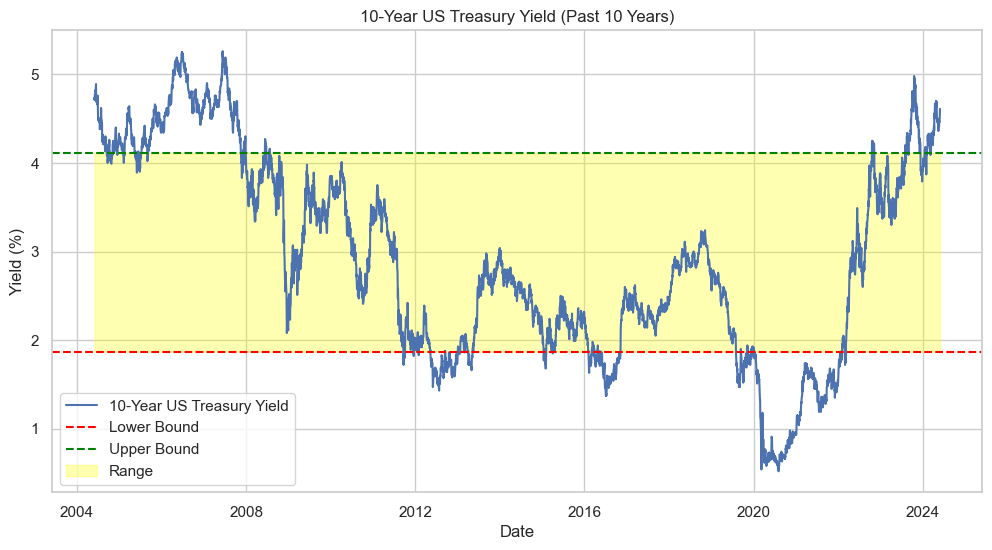

In [261]:
plt.figure(figsize=(12, 6))
plt.plot(cleaned_data['DATE'], cleaned_data['DGS10'], label='10-Year US Treasury Yield')
plt.axhline(y=lower_bound, color='red', linestyle='--', label='Lower Bound')
plt.axhline(y=upper_bound, color='green', linestyle='--', label='Upper Bound')
plt.fill_between(cleaned_data['DATE'],lower_bound, upper_bound, color='yellow', alpha=0.3, label='Range')
plt.title('10-Year US Treasury Yield (Past 10 Years)')
plt.xlabel('Date')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid(True)
plt.show()



We believe that after economic recovery, US 10 year treasury rate will come back to its original level